In [11]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# path to your specola database archive csv file, for more info visit:
# https://sunspots.irsol.usi.ch/db/choose-dl-year.php
specola_data_csv_file_path = './sunspot_data_excel.csv'

df = pd.read_csv(specola_data_csv_file_path)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# print the head to verify pandas is reading the file correctly
df.head()

,date,time,group nr.,weighted spot count,type,latitude,longitude
0,6/1/1957,7:55,275,2,J,-10.1,179.9
1,6/1/1957,7:55,278,19,H,21.4,157.9
2,6/1/1957,7:55,281,28,C,-22.5,129.8
3,6/1/1957,7:55,286,6,B,19.3,171.3
4,6/1/1957,7:55,288,15,C,-22.5,92.2


In [3]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
# Filter out rows where 'group nr.' is NaN or contains letters
# Group number of NAN indicates data wasnt available on that day/time
# Group number with letters indicates the observers were unsure if the sunspot was part of a particular group
df = df[df['group nr.'].notna() & df['group nr.'].apply(lambda x: re.match(r'^\d+$', str(x)) is not None)]

In [4]:
# undeveloped = ["A","B","C"]
# developed = ["D","E","F","G","H"]

In [5]:
# categorize all sunspots by undeveloped or developed based on if there type falls in this category
# if it the sunspot grows/decays between categories, than ignore it and set a marker
# calculate how many sunspots are changing between these 2 categories / total sunspot
# that will give us percent

In [6]:
#df['category'] = df['type'].apply(lambda x: 'Developed' if x in developed else 'Undeveloped' if x in undeveloped else 'Unknown')

In [9]:
# Unique list of years in the dataset
years = sorted(df['year'].unique())

# Initialize a dictionary to store the average lifespan by year
group_categories_global = []

list_of_percentages = {}
for year in years:
    # Filter the DataFrame for the current year
    df_year = df[df['year'] == year]

    # Initialize a dictionary to track the categories the sunspot groups appear for the current year
    group_categories = {}

    # Process each row -> looping through the current year and doing operations one row at a time
    for index, row in df_year.iterrows():
        group_number = row['group nr.']
        type1 = row['type']
        if group_number not in group_categories:
            # print(str(group_number) + " was not in list so we made one for it")
            group_categories[group_number] = [type1]        
        else:
            group_categories[group_number].append(type1)
        
    # Checks for potential overlaps by comparing the last two months of the current year
    # with the first two months of the next year. This can be extended to however many months you wish to filter
    if year + 1 in years:
        df_current_last_two_months = df[(df['year'] == year) & (df['month'] >= 11)]
        df_next_first_two_months = df[(df['year'] == year + 1) & (df['month'] <= 2)]

        for index, row in df_current_last_two_months.iterrows():

            group_number = row['group nr.']
            # Check if this group also appears in the next year's first two months
            df_next_group = df_next_first_two_months[df_next_first_two_months['group nr.'] == group_number]
            #that group appeared in the next year
            if not df_next_group.empty:
                #UNCOMMENT FOR DEBUG PURPOSES
                # print("this group appears in the next year {}".format(df_next_group['group nr.']))
                
                latest_next_year_type = df_next_group['type'].iloc[-1]
                #UNCOMMENT FOR DEBUG PURPOSES
                # print("latest appearance of the group in the next year is: {}".format(latest_next_year_date))
                if latest_next_year_type not in group_categories[group_number]:
                    group_categories[group_number].append(latest_next_year_type)
                    #UNCOMMENT FOR DEBUG PURPOSES
                    # print(group_dates[str(group_number)])

    # print(year)
    # print(group_categories)
    
    undeveloped = {"A", "B", "C"}
    developed = {"D", "E", "F", "G", "H"}

    total = 0
    total_swing = 0
    #now for each group
    for g_num, types in group_categories.items():
        status = False
        # Convert the list to a set for easier comparison
        sunspot_type_set = set(types)

        # Check if the sunspot group has types in both developed and undeveloped categories
        has_undeveloped = bool(sunspot_type_set & undeveloped)  # Check for intersection with undeveloped types
        has_developed = bool(sunspot_type_set & developed)      # Check for intersection with developed types

        # Determine if it falls in both categories
        if has_undeveloped and has_developed:
            # print("This sunspot group falls in both undeveloped and developed categories.")
            group_categories[g_num] = "swing"
            total_swing += 1
            total += 1
        else:
            # print("This sunspot group is consistent within a single category.")
            group_categories[g_num] = "good"
            total += 1
    
    list_of_percentages[year] = total_swing/total    

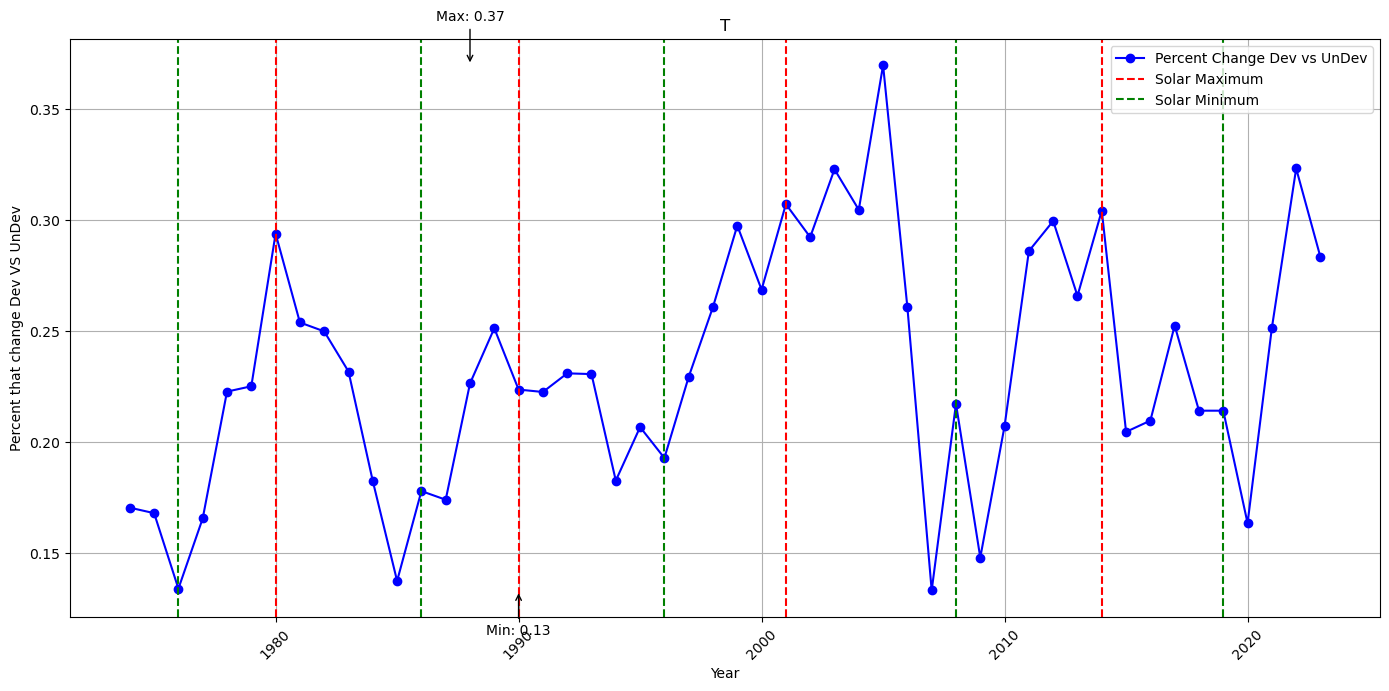

In [25]:
# Convert years to integers if they are in string format
years = [int(year) for year in years]

# Plotting the data
test = []
year_test = []
solar_maximum_years = [1980, 1990, 2001, 2014]  # ensure these are integers
solar_minimum_years = [1976, 1986, 1996, 2008, 2019]

for item, value in list_of_percentages.items():
    if item >= 1974:
        test.append(value)
        year_test.append(item)
    

# Plot the line graph
plt.figure(figsize=(14, 7))
plt.plot(year_test, test, marker='o', linestyle='-', color='b', label='Percent Change Dev vs UnDev')
plt.title('T')
plt.xlabel('Year')
plt.ylabel('Percent that change Dev VS UnDev')
plt.grid(True)
plt.xticks(rotation=45)

# Add dotted lines for solar maximum years (in red)
for max_year in solar_maximum_years:
    plt.axvline(x=max_year, color='red', linestyle='--', label='Solar Maximum' if max_year == solar_maximum_years[0] else '')

# Add dotted lines for solar minimum years (in green)
for min_year in solar_minimum_years:
    plt.axvline(x=min_year, color='green', linestyle='--', label='Solar Minimum' if min_year == solar_minimum_years[0] else '')

# Annotate max and min points
max_value = max(test)
min_value = min(test)
max_year = years[test.index(max_value)]
min_year = years[test.index(min_value)]

# Place annotation slightly above the maximum point
plt.annotate(f'Max: {max_value:.2f}', 
             xy=(max_year, max_value), 
             xytext=(max_year, max_value + 0.02),  # Adjust 0.02 for vertical offset if needed
             ha='center', 
             arrowprops=dict(facecolor='black', arrowstyle="->"))

# Place annotation slightly below the minimum point
plt.annotate(f'Min: {min_value:.2f}', 
             xy=(min_year, min_value), 
             xytext=(min_year, min_value - 0.02),  # Adjust 0.02 for vertical offset if needed
             ha='center', 
             arrowprops=dict(facecolor='black', arrowstyle="->"))

# Display legend
plt.legend()

plt.tight_layout()
plt.show()
